# ***Twitter Sentimenatal Analysis***

Dependencies

In [ ]:
import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import metrics
import seaborn as sns
import plotly.express as px
from matplotlib import pyplot as plt
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import collections
import matplotlib.cm as cm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
import string
import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Load dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


data is our dataframe. It have 6 different columns ("target", "ids", "date", "flag", "user", "text")

target column is for sentiment label. The tweets have been annotated (0 = negative, 2 = neutral, 4 = positive) and they can be used to detect sentiment. Each tweet has unique id, data, flag and user. We have used ISO_8859-1 encoding and removed all null values.

In [ ]:
missing_values = ["n/a","na","--","-","**","*"]
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
data = pd.read_csv("/content/drive/MyDrive/Kaggle/training.1600000.processed.noemoticon.csv",na_values=missing_values, encoding='ISO-8859-1')
data.columns = DATASET_COLUMNS
data.head()

,target,ids,date,flag,user,text
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


First tweet

In [ ]:
data['text'].values[0]

"is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!"

data types of each column

In [ ]:
data.dtypes

target     int64
ids        int64
date      object
flag      object
user      object
text      object
dtype: object

Check for null values

In [ ]:
data.isnull().any()

target    False
ids       False
date      False
flag      False
user      False
text      False
dtype: bool

Shape of dataset. In our dataset there are total 1599999 tweets data with other details in 6 different column.

In [ ]:
data.shape

(1599999, 6)

Plot the count for each target

In [ ]:
data['target'].value_counts()

4    800000
0    799999
Name: target, dtype: int64

In our dataset there are total 800000 entries for label 4 (positive) and 799999 entries with label 0 (negative). there is no data with label 2 (Neutral).

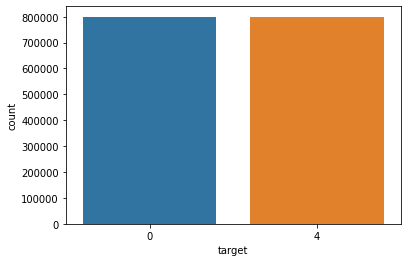

In [ ]:
sns.countplot(data['target']);

[799999, 800000]


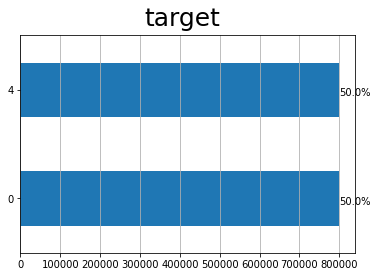

In [ ]:
ax = data[ 'target'].value_counts().sort_values().plot(kind="barh")
totals= []
for i in ax.patches:
    totals.append(i.get_width())
print(totals)
total = sum(totals)
for i in ax.patches:
     ax.text(i.get_width()+.3, i.get_y()+.20, 
     str(round((i.get_width()/total)*100, 2))+'%', 
     fontsize=10, color='black')
ax.grid(axis="x")
plt.suptitle('target', fontsize=25)
plt.show()

Dataset description.

In [ ]:
data.describe(include=np.object)

,date,flag,user,text
count,1599999,1599999,1599999,1599999
unique,774362,1,659775,1581465
top,Mon Jun 15 12:53:14 PDT 2009,NO_QUERY,lost_dog,isPlayer Has Died! Sorry
freq,20,1599999,549,210


Splitted dataset for target 0(negative) and target 1(positive)

In [ ]:
data_target_0 = data.loc[data['target']==0]
data_target_1 = data.loc[data['target']==4]

In [ ]:
data_target_0

,target,ids,date,flag,user,text
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew
...,...,...,...,...,...,...
799994,0,2329205009,Thu Jun 25 10:28:28 PDT 2009,NO_QUERY,dandykim,Sick Spending my day laying in bed listening ...
799995,0,2329205038,Thu Jun 25 10:28:28 PDT 2009,NO_QUERY,bigenya,Gmail is down?
799996,0,2329205473,Thu Jun 25 10:28:30 PDT 2009,NO_QUERY,LeeLHoke,rest in peace Farrah! So sad
799997,0,2329205574,Thu Jun 25 10:28:30 PDT 2009,NO_QUERY,davidlmulder,@Eric_Urbane Sounds like a rival is flagging y...


In [ ]:
data_target_1

,target,ids,date,flag,user,text
799999,4,1467822272,Mon Apr 06 22:22:45 PDT 2009,NO_QUERY,ersle,I LOVE @Health4UandPets u guys r the best!!
800000,4,1467822273,Mon Apr 06 22:22:45 PDT 2009,NO_QUERY,becca210,im meeting up with one of my besties tonight! ...
800001,4,1467822283,Mon Apr 06 22:22:46 PDT 2009,NO_QUERY,Wingman29,"@DaRealSunisaKim Thanks for the Twitter add, S..."
800002,4,1467822287,Mon Apr 06 22:22:46 PDT 2009,NO_QUERY,katarinka,Being sick can be really cheap when it hurts t...
800003,4,1467822293,Mon Apr 06 22:22:46 PDT 2009,NO_QUERY,_EmilyYoung,@LovesBrooklyn2 he has that effect on everyone
...,...,...,...,...,...,...
1599994,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599995,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599996,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599997,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...


Average length and average word count for given dataset

In [ ]:
print("Average tweet Length : ",data['text'].str.len().mean())
print("Average word count in the tweets : ",data['text'].str.split().apply(lambda x: len(x)).mean())

Average tweet Length :  74.09008568130355
Average word count in the tweets :  13.176146985091865


maximum length of tweet 374

In [ ]:
data['text'].str.len().max()

374

minimum length of tweet = 6

In [ ]:
data['text'].str.len().min()

6

tweets with length = minimum tweet length

In [ ]:
data.loc[data['text'].str.len()==data['text'].str.len().min()]

,target,ids,date,flag,user,text
4232,0,1468771833,Tue Apr 07 03:39:06 PDT 2009,NO_QUERY,goldieloxx,just
209109,0,1973889928,Sat May 30 12:01:58 PDT 2009,NO_QUERY,PhoebeKaye11,ouch
310553,0,2001120036,Mon Jun 01 23:54:07 PDT 2009,NO_QUERY,Loois9,Ugh
1050598,4,1960762577,Fri May 29 08:28:02 PDT 2009,NO_QUERY,this_kid2008,hey
1071085,4,1966267712,Fri May 29 17:26:49 PDT 2009,NO_QUERY,Jsstar0273,Yes
1229946,4,1991474399,Mon Jun 01 07:06:16 PDT 2009,NO_QUERY,kimmms,and*


tweet with minimum word i.e tweet with 1 word only

In [ ]:
#tweets with minimum word length
data.loc[data['text'].str.split().apply(lambda x: len(x))==data['text'].str.split().apply(lambda x: len(x)).min()]


,target,ids,date,flag,user,text
134,0,1467842448,Mon Apr 06 22:28:05 PDT 2009,NO_QUERY,R_Boucher,Agh...snow!!!
207,0,1467863072,Mon Apr 06 22:33:25 PDT 2009,NO_QUERY,Artiel87,@mandayyy
248,0,1467874569,Mon Apr 06 22:36:27 PDT 2009,NO_QUERY,Artiel87,@mandayyy
356,0,1467900545,Mon Apr 06 22:43:31 PDT 2009,NO_QUERY,brookes4402,homework....
397,0,1467912842,Mon Apr 06 22:46:53 PDT 2009,NO_QUERY,KimberlyKane,@danadearmond
...,...,...,...,...,...,...
1597577,4,2192960609,Tue Jun 16 07:48:02 PDT 2009,NO_QUERY,xXmaraXxW,nothing
1598624,4,2193223303,Tue Jun 16 08:09:52 PDT 2009,NO_QUERY,hvhuynh,goodmornin
1599493,4,2193453573,Tue Jun 16 08:28:48 PDT 2009,NO_QUERY,RobNice24,@Sworn4DaBosses
1599677,4,2193503347,Tue Jun 16 08:32:47 PDT 2009,NO_QUERY,ShaneLemmon,goodmorning


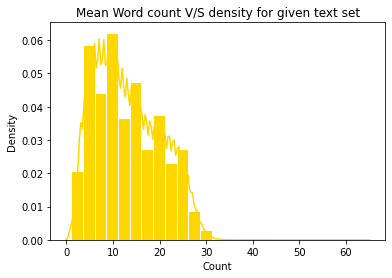

In [ ]:
plt.title("Mean Word count V/S density for given text set")
data_wl = data['text'].str.split().apply(lambda x: len(x))
sns.set(style='whitegrid', palette="deep", font_scale=1.1, rc={"figure.figsize": [7, 7]})
sns.distplot(
    data_wl.map(lambda x: np.mean(x)), norm_hist=False, kde=True,color="gold", bins=25, hist_kws={"alpha": 1}
).set(xlabel='Count');

Plot tells us that there are more number of tweets data with word cout between range 5-17

Average length and average word count for given class 1.

In [ ]:
print("Average tweet Length for target 1 : ",data_target_1['text'].str.len().mean())
print("Average word count in the tweets for target 1: ",data_target_1['text'].str.split().apply(lambda x: len(x)).mean())

Average tweet Length for target 1 :  73.8784325
Average word count in the tweets for target 1:  12.7703175


tweet's word count V/S density plot for class 1

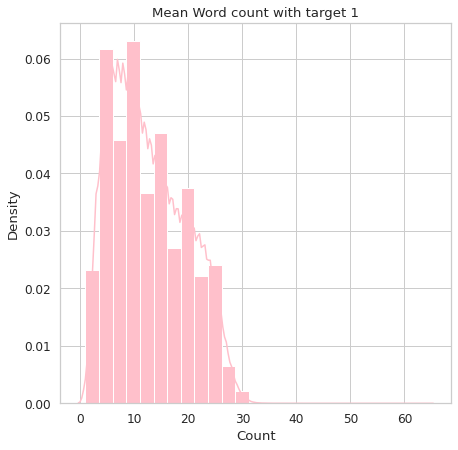

In [ ]:
plt.title("Mean Word count with target 1")
data_target_1_wl = data_target_1['text'].str.split().apply(lambda x: len(x))
sns.set(style='whitegrid', palette="deep", font_scale=1.1, rc={"figure.figsize": [7, 7]})
sns.distplot(
    data_target_1_wl.map(lambda x: np.mean(x)), norm_hist=False, kde=True,color="pink", bins=25, hist_kws={"alpha": 1}
).set(xlabel='Count');


Plot tells us that there are more number of tweets data with word cout between range 5-17

Average length and average word count for given class 0.

In [ ]:
print("Average tweet Length for target 0: ",data_target_0['text'].str.len().mean())
print("Average word count in the tweets for target 0: ",data_target_0['text'].str.split().apply(lambda x: len(x)).mean())

Average tweet Length for target 0:  74.3017391271739
Average word count in the tweets for target 0:  13.581976977471221


tweet's word count V/S density plot for class 0

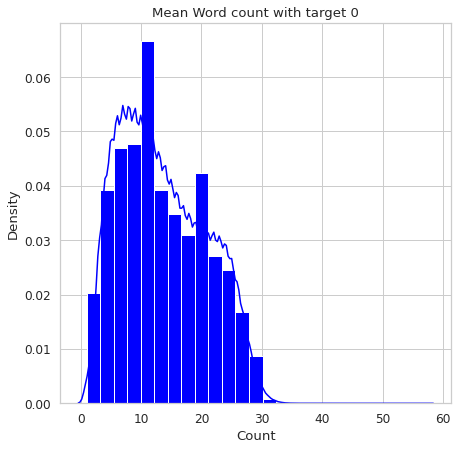

In [ ]:
plt.title("Mean Word count with target 0")
data_target_0_wl = data_target_0['text'].str.split().apply(lambda x: len(x))
sns.set(style='whitegrid', palette="deep", font_scale=1.1, rc={"figure.figsize": [7, 7]})
sns.distplot(
    data_target_0_wl.map(lambda x: np.mean(x)), norm_hist=False, kde=True,color="blue", bins=25, hist_kws={"alpha": 1}
).set(xlabel='Count');

# Preprocessing

Remove:


1.   Extra Spaces
2.   Lowercase
2.   HTMLParser 
2.   Hypens and arrows
3.   Emojis
4.   URL
5.   Any other non english or special symbol

Replace wrong spellings with correct spellings



## Removing extra spaces

In [ ]:
# Function to remove extra spaces
def Remove_Extra_Spaces(text):
	target_pattern = r'\s+'
	text_without_extra_space = re.sub(pattern=target_pattern, repl=" ", string=text)
	return text_without_extra_space

In [ ]:
# to verify function is working correctly
Remove_Extra_Spaces("tree      yhft  hdygd bgft")

'tree yhft hdygd bgft'

In [ ]:
# Apply function on given dataset
data['text'] = data['text'].apply(Remove_Extra_Spaces)

In [ ]:
data.head()

,target,ids,date,flag,user,text
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


## Converting text to lower case

In [ ]:
data.head()

,target,ids,date,flag,user,text
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [ ]:
# Apply lower function on given dataset
data['text'] = data['text'].str.lower()
data.head()

,target,ids,date,flag,user,text
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@kenichan i dived many times for the ball. man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@kwesidei not the whole crew


##HTMLParser

In [ ]:
# Importing HTMLParser
from html.parser import HTMLParser
# Parser object
html_parser = HTMLParser()

In [ ]:
# Apply parser on given dataset
data['text'] = data['text'].apply(lambda x: html_parser.unescape(x))
data.head()

,target,ids,date,flag,user,text
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@kenichan i dived many times for the ball. man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@kwesidei not the whole crew


## Handle apostrophe

In [ ]:
# Apostrophe Dictionary
apostrophe_dict = {
"ain't": "am not / are not",
"aren't": "are not / am not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had / he would",
"he'd've": "he would have",
"he'll": "he shall / he will",
"he'll've": "he shall have / he will have",
"he's": "he has / he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has / how is",
"i'd": "i had / i would",
"i'd've": "i would have",
"i'll": "i shall / i will",
"i'll've": "i shall have / i will have",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it had / it would",
"it'd've": "it would have",
"it'll": "it shall / it will",
"it'll've": "it shall have / it will have",
"it's": "it has / it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had / she would",
"she'd've": "she would have",
"she'll": "she shall / she will",
"she'll've": "she shall have / she will have",
"she's": "she has / she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as / so is",
"that'd": "that would / that had",
"that'd've": "that would have",
"that's": "that has / that is",
"there'd": "there had / there would",
"there'd've": "there would have",
"there's": "there has / there is",
"they'd": "they had / they would",
"they'd've": "they would have",
"they'll": "they shall / they will",
"they'll've": "they shall have / they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had / we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall / what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what has / what is",
"what've": "what have",
"when's": "when has / when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has / where is",
"where've": "where have",
"who'll": "who shall / who will",
"who'll've": "who shall have / who will have",
"who's": "who has / who is",
"who've": "who have",
"why's": "why has / why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had / you would",
"you'd've": "you would have",
"you'll": "you shall / you will",
"you'll've": "you shall have / you will have",
"you're": "you are",
"you've": "you have"
}

In [ ]:
def lookup_dict(text, dictionary):
    for word in text.split():
        if word.lower() in dictionary:
            if word.lower() in text.split():
                text = text.replace(word, dictionary[word.lower()])
    return text

In [ ]:
# Apply apostrophe handler/converter on given dataset
data['text'] = data['text'].apply(lambda x: lookup_dict(x,apostrophe_dict))
data.head(10)

,target,ids,date,flag,user,text
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he cannot update his facebook by...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@kenichan i dived many times for the ball. man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it has / it is not behavi..."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@kwesidei not the whole crew
5,0,1467811592,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,mybirch,need a hug
6,0,1467811594,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,coZZ,@loltrish hey long time no see! yes.. rains a ...
7,0,1467811795,Mon Apr 06 22:20:05 PDT 2009,NO_QUERY,2Hood4Hollywood,@tatiana_k nope they did not have it
8,0,1467812025,Mon Apr 06 22:20:09 PDT 2009,NO_QUERY,mimismo,@twittera que me muera ?
9,0,1467812416,Mon Apr 06 22:20:16 PDT 2009,NO_QUERY,erinx3leannexo,spring break in plain city... it has / it is s...


## Handle short words

In [ ]:
short_word_dict = {
"121": "one to one",
"a/s/l": "age, sex, location",
"adn": "any day now",
"afaik": "as far as i know",
"afk": "away from keyboard",
"aight": "alright",
"alol": "actually laughing out loud",
"b4": "before",
"b4n": "bye for now",
"bak": "back at the keyboard",
"bf": "boyfriend",
"bff": "best friends forever",
"bfn": "bye for now",
"bg": "big grin",
"bta": "but then again",
"btw": "by the way",
"cid": "crying in disgrace",
"cnp": "continued in my next post",
"cp": "chat post",
"cu": "see you",
"cul": "see you later",
"cul8r": "see you later",
"cya": "bye",
"cyo": "see you online",
"dbau": "doing business as usual",
"fud": "fear, uncertainty, and doubt",
"fwiw": "for what it's worth",
"fyi": "for your information",
"g": "grin",
"g2g": "got to go",
"ga": "go ahead",
"gal": "get a life",
"gf": "girlfriend",
"gfn": "gone for now",
"gmbo": "giggling my butt off",
"gmta": "great minds think alike",
"h8": "hate",
"hagn": "have a good night",
"hdop": "help delete online predators",
"hhis": "hanging head in shame",
"iac": "in any case",
"ianal": "i am not a lawyer",
"ic": "i see",
"idk": "i don't know",
"imao": "in my arrogant opinion",
"imnsho": "in my not so humble opinion",
"imo": "in my opinion",
"iow": "in other words",
"ipn": "i’m posting naked",
"irl": "in real life",
"jk": "just kidding",
"l8r": "later",
"ld": "later, dude",
"ldr": "long distance relationship",
"llta": "lots and lots of thunderous applause",
"lmao": "laugh my ass off",
"lmirl": "let's meet in real life",
"lol": "laugh out loud",
"ltr": "longterm relationship",
"lulab": "love you like a brother",
"lulas": "love you like a sister",
"luv": "love",
"m/f": "male or female",
"m8": "mate",
"milf": "mother i would like to fuck",
"oll": "online love",
"omg": "oh my god",
"otoh": "on the other hand",
"pir": "parent in room",
"ppl": "people",
"r": "are",
"rofl": "roll on the floor laughing",
"rpg": "role playing games",
"ru": "are you",
"shid": "slaps head in disgust",
"somy": "sick of me yet",
"sot": "short of time",
"thanx": "thanks",
"thx": "thanks",
"ttyl": "talk to you later",
"u": "you",
"ur": "you are",
"uw": "you’re welcome",
"wb": "welcome back",
"wfm": "works for me",
"wibni": "wouldn't it be nice if",
"wtf": "what the fuck",
"wtg": "way to go",
"wtgp": "want to go private",
"ym": "young man",
"gr8": "great"
}

In [ ]:
# Apply short word handler/converter on given dataset
data['text'] = data['text'].apply(lambda x: lookup_dict(x,short_word_dict))
data.head(10)

,target,ids,date,flag,user,text
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he cannot update his facebook by...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@kenichan i dived many times for the ball. man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it has / it is not behavi..."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@kwesidei not the whole crew
5,0,1467811592,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,mybirch,need a hug
6,0,1467811594,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,coZZ,@laugh out loudtrish hey long time no see! yes...
7,0,1467811795,Mon Apr 06 22:20:05 PDT 2009,NO_QUERY,2Hood4Hollywood,@tatiana_k nope they did not have it
8,0,1467812025,Mon Apr 06 22:20:09 PDT 2009,NO_QUERY,mimismo,@twittera que me muera ?
9,0,1467812416,Mon Apr 06 22:20:16 PDT 2009,NO_QUERY,erinx3leannexo,spring break in plain city... it has / it is s...


## Removing stopwords

Common stopwords list in english

In [ ]:
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [ ]:
data.head()

,target,ids,date,flag,user,text
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he cannot update his facebook by...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@kenichan i dived many times for the ball. man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it has / it is not behavi..."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@kwesidei not the whole crew


In [ ]:
STOPWORDS = set(stopwords.words('english'))
# Custom function to remove the stopwords
def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

# Apply stopwords removal function on given dataset. It help us to remove words with no/low information
data["text"] = data["text"].apply(lambda text: remove_stopwords(text))
data.head()

,target,ids,date,flag,user,text
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,upset cannot update facebook texting it... mig...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@kenichan dived many times ball. managed save ...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,whole body feels itchy like fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, / behaving all. mad. here..."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@kwesidei whole crew


## Removing URLs

In [ ]:
# Function to remove urls
def remove_url(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

In [ ]:
#Verifying whether this function works properly or not
text_1 = "Driverless AI NLP blog post on https://www.h2o.ai/blog/detecting-sarcasm-is-difficult-but-ai-may-have-an-answer/"
print("text_1 updated : ",remove_url(text_1))
text_2 = "Please refer to link http://lnkd.in/ecnt5yC for the paper"
print("text_2 updated : ",remove_url(text_2))
text_3 = "Want to know more. Checkout www.h2o.ai for additional information"
print("text_3 updated : ",remove_url(text_3))

text_1 updated :  Driverless AI NLP blog post on 
text_2 updated :  Please refer to link  for the paper
text_3 updated :  Want to know more. Checkout  for additional information


In [ ]:
# Apply url removal function on given dataset.
data["text"] = data["text"].apply(lambda text: remove_url(text))
data.head()

,target,ids,date,flag,user,text
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,upset cannot update facebook texting it... mig...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@kenichan dived many times ball. managed save ...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,whole body feels itchy like fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, / behaving all. mad. here..."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@kwesidei whole crew


## Removing of emojis and emoticons

In [ ]:
# Function to remove emojis
def remove_emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)
remove_emoji("progress is on 🔥🔥")

'progress is on '

In [ ]:
# Apply emoji removal function on given texts
data['text'] = data['text'].apply(remove_emoji)

In [ ]:
# Emoticons list
EMOTICONS = {
    u":‑\)":"Happy face or smiley",
    u":\)":"Happy face or smiley",
    u":-\]":"Happy face or smiley",
    u":\]":"Happy face or smiley",
    u":-3":"Happy face smiley",
    u":3":"Happy face smiley",
    u":->":"Happy face smiley",
    u":>":"Happy face smiley",
    u"8-\)":"Happy face smiley",
    u":o\)":"Happy face smiley",
    u":-\}":"Happy face smiley",
    u":\}":"Happy face smiley",
    u":-\)":"Happy face smiley",
    u":c\)":"Happy face smiley",
    u":\^\)":"Happy face smiley",
    u"=\]":"Happy face smiley",
    u"=\)":"Happy face smiley",
    u":‑D":"Laughing, big grin or laugh with glasses",
    u":D":"Laughing, big grin or laugh with glasses",
    u"8‑D":"Laughing, big grin or laugh with glasses",
    u"8D":"Laughing, big grin or laugh with glasses",
    u"X‑D":"Laughing, big grin or laugh with glasses",
    u"XD":"Laughing, big grin or laugh with glasses",
    u"=D":"Laughing, big grin or laugh with glasses",
    u"=3":"Laughing, big grin or laugh with glasses",
    u"B\^D":"Laughing, big grin or laugh with glasses",
    u":-\)\)":"Very happy",
    u":‑\(":"Frown, sad, andry or pouting",
    u":-\(":"Frown, sad, andry or pouting",
    u":\(":"Frown, sad, andry or pouting",
    u":‑c":"Frown, sad, andry or pouting",
    u":c":"Frown, sad, andry or pouting",
    u":‑<":"Frown, sad, andry or pouting",
    u":<":"Frown, sad, andry or pouting",
    u":‑\[":"Frown, sad, andry or pouting",
    u":\[":"Frown, sad, andry or pouting",
    u":-\|\|":"Frown, sad, andry or pouting",
    u">:\[":"Frown, sad, andry or pouting",
    u":\{":"Frown, sad, andry or pouting",
    u":@":"Frown, sad, andry or pouting",
    u">:\(":"Frown, sad, andry or pouting",
    u":'‑\(":"Crying",
    u":'\(":"Crying",
    u":'‑\)":"Tears of happiness",
    u":'\)":"Tears of happiness",
    u"D‑':":"Horror",
    u"D:<":"Disgust",
    u"D:":"Sadness",
    u"D8":"Great dismay",
    u"D;":"Great dismay",
    u"D=":"Great dismay",
    u"DX":"Great dismay",
    u":‑O":"Surprise",
    u":O":"Surprise",
    u":‑o":"Surprise",
    u":o":"Surprise",
    u":-0":"Shock",
    u"8‑0":"Yawn",
    u">:O":"Yawn",
    u":-\*":"Kiss",
    u":\*":"Kiss",
    u":X":"Kiss",
    u";‑\)":"Wink or smirk",
    u";\)":"Wink or smirk",
    u"\*-\)":"Wink or smirk",
    u"\*\)":"Wink or smirk",
    u";‑\]":"Wink or smirk",
    u";\]":"Wink or smirk",
    u";\^\)":"Wink or smirk",
    u":‑,":"Wink or smirk",
    u";D":"Wink or smirk",
    u":‑P":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":P":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"X‑P":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"XP":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":‑Þ":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":Þ":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":b":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"d:":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"=p":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u">:P":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":‑/":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":/":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":-[.]":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u">:[(\\\)]":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u">:/":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":[(\\\)]":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u"=/":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u"=[(\\\)]":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":L":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u"=L":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":S":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":‑\|":"Straight face",
    u":\|":"Straight face",
    u":$":"Embarrassed or blushing",
    u":‑x":"Sealed lips or wearing braces or tongue-tied",
    u":x":"Sealed lips or wearing braces or tongue-tied",
    u":‑#":"Sealed lips or wearing braces or tongue-tied",
    u":#":"Sealed lips or wearing braces or tongue-tied",
    u":‑&":"Sealed lips or wearing braces or tongue-tied",
    u":&":"Sealed lips or wearing braces or tongue-tied",
    u"O:‑\)":"Angel, saint or innocent",
    u"O:\)":"Angel, saint or innocent",
    u"0:‑3":"Angel, saint or innocent",
    u"0:3":"Angel, saint or innocent",
    u"0:‑\)":"Angel, saint or innocent",
    u"0:\)":"Angel, saint or innocent",
    u":‑b":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"0;\^\)":"Angel, saint or innocent",
    u">:‑\)":"Evil or devilish",
    u">:\)":"Evil or devilish",
    u"\}:‑\)":"Evil or devilish",
    u"\}:\)":"Evil or devilish",
    u"3:‑\)":"Evil or devilish",
    u"3:\)":"Evil or devilish",
    u">;\)":"Evil or devilish",
    u"\|;‑\)":"Cool",
    u"\|‑O":"Bored",
    u":‑J":"Tongue-in-cheek",
    u"#‑\)":"Party all night",
    u"%‑\)":"Drunk or confused",
    u"%\)":"Drunk or confused",
    u":-###..":"Being sick",
    u":###..":"Being sick",
    u"<:‑\|":"Dump",
    u"\(>_<\)":"Troubled",
    u"\(>_<\)>":"Troubled",
    u"\(';'\)":"Baby",
    u"\(\^\^>``":"Nervous or Embarrassed or Troubled or Shy or Sweat drop",
    u"\(\^_\^;\)":"Nervous or Embarrassed or Troubled or Shy or Sweat drop",
    u"\(-_-;\)":"Nervous or Embarrassed or Troubled or Shy or Sweat drop",
    u"\(~_~;\) \(・\.・;\)":"Nervous or Embarrassed or Troubled or Shy or Sweat drop",
    u"\(-_-\)zzz":"Sleeping",
    u"\(\^_-\)":"Wink",
    u"\(\(\+_\+\)\)":"Confused",
    u"\(\+o\+\)":"Confused",
    u"\(o\|o\)":"Ultraman",
    u"\^_\^":"Joyful",
    u"\(\^_\^\)/":"Joyful",
    u"\(\^O\^\)／":"Joyful",
    u"\(\^o\^\)／":"Joyful",
    u"\(__\)":"Kowtow as a sign of respect, or dogeza for apology",
    u"_\(\._\.\)_":"Kowtow as a sign of respect, or dogeza for apology",
    u"<\(_ _\)>":"Kowtow as a sign of respect, or dogeza for apology",
    u"<m\(__\)m>":"Kowtow as a sign of respect, or dogeza for apology",
    u"m\(__\)m":"Kowtow as a sign of respect, or dogeza for apology",
    u"m\(_ _\)m":"Kowtow as a sign of respect, or dogeza for apology",
    u"\('_'\)":"Sad or Crying",
    u"\(/_;\)":"Sad or Crying",
    u"\(T_T\) \(;_;\)":"Sad or Crying",
    u"\(;_;":"Sad of Crying",
    u"\(;_:\)":"Sad or Crying",
    u"\(;O;\)":"Sad or Crying",
    u"\(:_;\)":"Sad or Crying",
    u"\(ToT\)":"Sad or Crying",
    u";_;":"Sad or Crying",
    u";-;":"Sad or Crying",
    u";n;":"Sad or Crying",
    u";;":"Sad or Crying",
    u"Q\.Q":"Sad or Crying",
    u"T\.T":"Sad or Crying",
    u"QQ":"Sad or Crying",
    u"Q_Q":"Sad or Crying",
    u"\(-\.-\)":"Shame",
    u"\(-_-\)":"Shame",
    u"\(一一\)":"Shame",
    u"\(；一_一\)":"Shame",
    u"\(=_=\)":"Tired",
    u"\(=\^\·\^=\)":"cat",
    u"\(=\^\·\·\^=\)":"cat",
    u"=_\^=	":"cat",
    u"\(\.\.\)":"Looking down",
    u"\(\._\.\)":"Looking down",
    u"\^m\^":"Giggling with hand covering mouth",
    u"\(\・\・?":"Confusion",
    u"\(?_?\)":"Confusion",
    u">\^_\^<":"Normal Laugh",
    u"<\^!\^>":"Normal Laugh",
    u"\^/\^":"Normal Laugh",
    u"\（\*\^_\^\*）" :"Normal Laugh",
    u"\(\^<\^\) \(\^\.\^\)":"Normal Laugh",
    u"\(^\^\)":"Normal Laugh",
    u"\(\^\.\^\)":"Normal Laugh",
    u"\(\^_\^\.\)":"Normal Laugh",
    u"\(\^_\^\)":"Normal Laugh",
    u"\(\^\^\)":"Normal Laugh",
    u"\(\^J\^\)":"Normal Laugh",
    u"\(\*\^\.\^\*\)":"Normal Laugh",
    u"\(\^—\^\）":"Normal Laugh",
    u"\(#\^\.\^#\)":"Normal Laugh",
    u"\（\^—\^\）":"Waving",
    u"\(;_;\)/~~~":"Waving",
    u"\(\^\.\^\)/~~~":"Waving",
    u"\(-_-\)/~~~ \($\·\·\)/~~~":"Waving",
    u"\(T_T\)/~~~":"Waving",
    u"\(ToT\)/~~~":"Waving",
    u"\(\*\^0\^\*\)":"Excited",
    u"\(\*_\*\)":"Amazed",
    u"\(\*_\*;":"Amazed",
    u"\(\+_\+\) \(@_@\)":"Amazed",
    u"\(\*\^\^\)v":"Laughing,Cheerful",
    u"\(\^_\^\)v":"Laughing,Cheerful",
    u"\(\(d[-_-]b\)\)":"Headphones,Listening to music",
    u'\(-"-\)':"Worried",
    u"\(ーー;\)":"Worried",
    u"\(\^0_0\^\)":"Eyeglasses",
    u"\(\＾ｖ\＾\)":"Happy",
    u"\(\＾ｕ\＾\)":"Happy",
    u"\(\^\)o\(\^\)":"Happy",
    u"\(\^O\^\)":"Happy",
    u"\(\^o\^\)":"Happy",
    u"\)\^o\^\(":"Happy",
    u":O o_O":"Surprised",
    u"o_0":"Surprised",
    u"o\.O":"Surpised",
    u"\(o\.o\)":"Surprised",
    u"oO":"Surprised",
    u"\(\*￣m￣\)":"Dissatisfied",
    u"\(‘A`\)":"Snubbed or Deflated"
}

In [ ]:
# Function to remove emoticons
def remove_emoticons(text):
    emoticon_pattern = re.compile(u'(' + u'|'.join(k for k in EMOTICONS) + u')')
    return emoticon_pattern.sub(r'', text)

In [ ]:
# Apply function on given texts
data['text']=data['text'].apply(remove_emoticons)

## Removing punctuation

different available punctuation

In [ ]:
print(string.punctuation)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [ ]:
# Punctuation removal function
def remove_punctuation(input1):
    temp = str.maketrans('','',string.punctuation)
    return input1.translate(temp)

In [ ]:
# Verifying function
txt = "hey, hello!"
print(remove_punctuation(txt))

hey hello


In [ ]:
data.head(7)

,target,ids,date,flag,user,text
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,upset cannot update facebook texting it... mig...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@kenichan dived many times ball. managed save ...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,whole body feels itchy like fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, / behaving all. mad. here..."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@kwesidei whole crew
5,0,1467811592,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,mybirch,need hug
6,0,1467811594,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,coZZ,@laugh loudtrish hey long time see! yes.. rain...


In [ ]:
# Apply punctuation removal on dataset
data['text'] = data['text'].apply(remove_punctuation)
data.head(7)

,target,ids,date,flag,user,text
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,upset cannot update facebook texting it might ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,kenichan dived many times ball managed save 50...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,whole body feels itchy like fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,nationwideclass no behaving all mad here cann...
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,kwesidei whole crew
5,0,1467811592,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,mybirch,need hug
6,0,1467811594,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,coZZ,laugh loudtrish hey long time see yes rains bi...


## function to remove Symbols 

In [ ]:
# tweet with symbols
data.iloc[1484881,:]['text']

'iannnnn à¹\x80à¸\x94à¸µà¹\x8bà¸¢à¸§à¸\xadà¸µà¸à¸\x8bà¸±à¸à¸\x84à¸£à¸¹à¹\x88à¸\x84à¸\x87à¹\x80à¸£à¸µà¸¢à¸à¸\x97à¸µà¸¡ graphic à¹\x80à¸\x82à¹\x89à¸²à¸¡à¸²à¹à¸¥à¹\x89à¸§à¸\x9bà¸£à¸±à¸\x9aà¹\x80à¸¥à¹\x87à¸à¸\x99à¹\x89à¸\xadà¸¢à¹\x83à¸«à¹\x89à¸¡à¸±à¸\x99à¸\x84à¸¥à¹\x89à¸²à¸¢à¸à¸±à¸\x99à¸¢à¸´à¹\x88à¸\x87à¸\x82à¸¶à¹\x89à¸\x99à¸\x84à¸£à¸±à¸\x9a à¹\x80à¸\x9eà¸£à¸²à¸°à¸«à¸²à¸à¹\x80à¸\xadà¸²à¸¡à¸²à¹\x80à¸\x97à¸µà¸¢à¸\x9aà¸à¸±à¸\x99à¸\x84à¸\x87à¸¡à¸µà¸\x9bà¸±à¸à¸«à¸²à¸\xadà¸¢à¹\x88à¸²à¸\x87à¸§à¹\x88à¸²à¸\x84à¸£à¸±à¸\x9a'

In [ ]:
# Function to remove symbols (non-alphabate characters)
def Remove_Symbols(text): 
    return ''.join(i for i in text if ord(i)<123) 

data['text'] = data['text'].apply(Remove_Symbols) 
data.head()

,target,ids,date,flag,user,text
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,upset cannot update facebook texting it might ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,kenichan dived many times ball managed save 50...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,whole body feels itchy like fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,nationwideclass no behaving all mad here cann...
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,kwesidei whole crew


In [ ]:
# To check function is working correctly or not
data.iloc[1484881,:]['text']

'iannnnn  graphic  '

## Spelling correction

In [ ]:
from textblob import TextBlob

In [ ]:
# Spelling correction is a cool feature which TextBlob offers, we can be accessed using the correct function as shown below.
blob = TextBlob("Why are you stting on this bech??") # Scentence with two errors
print(blob.correct()) # Correct function give us the best possible word simmilar to "gret"

Why are you sitting on this bench??


In [ ]:
data['text'] = data['text'].apply(lambda x: str(TextBlob(x).correct()))
data.head()

## Lemmatization with POS = verb

To convert words like building => build

In [ ]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
def lemmatize_word(text):
  return " ".join([lemmatizer.lemmatize(word, 'v') for word in text.split()])

data['text'] = data['text'].apply(lambda text: lemmatize_word(text))
data.head()

,target,text
0,0,upset cannot update facebook texting it might ...
1,0,kenichan dive many time ball manage save 50 re...
2,0,whole body feel itchy like fire
3,0,nationwideclass no behave all mad here cannot ...
4,0,kwesidei whole crew


In [ ]:
# To test Lemmatization function
lemmatize_word("crying testing ablaze")

'cry test ablaze'

## Plot a word cloud of real target and fake target

In [ ]:
# Function to buil corpus from given text data
def build_corpus(column):
    corpus = []
    for i in column.str.split():
        for word in i:
            corpus.append(word)
    return corpus

In [ ]:
data_target_0 = data.loc[data['target']==0]
data_target_1 = data.loc[data['target']==4]

In [ ]:
fake_corpus = build_corpus(data_target_0['text'])
print(len(fake_corpus))

6286937


Text corpus for negative class

In [ ]:
fake_text_corpus = " ".join(fake_corpus)
len(fake_text_corpus)

38089527

Word cloud of negative class

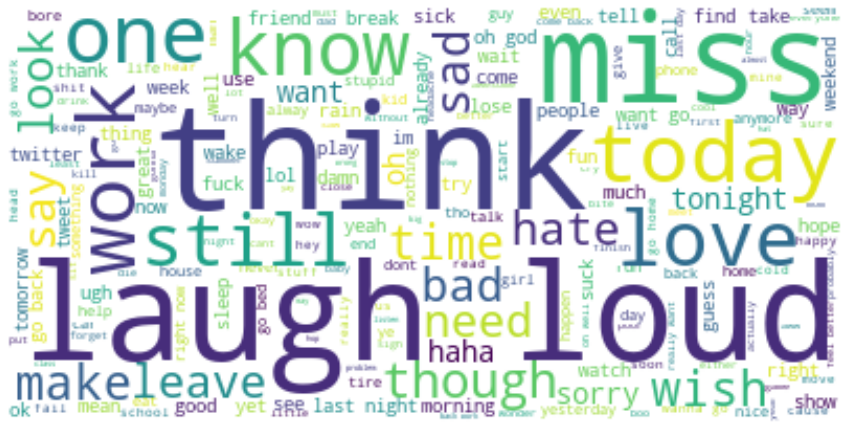

In [ ]:
wordcloud_fake = WordCloud(background_color="white").generate(fake_text_corpus)

plt.figure(figsize = (15,15))
plt.imshow(wordcloud_fake, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
real_corpus = build_corpus(data_target_1['text'])
print(len(real_corpus))

6146441


Text corpus of positive class

In [ ]:
real_text_corpus = " ".join(real_corpus)
len(real_text_corpus)

38724734

Word cloud of positive class

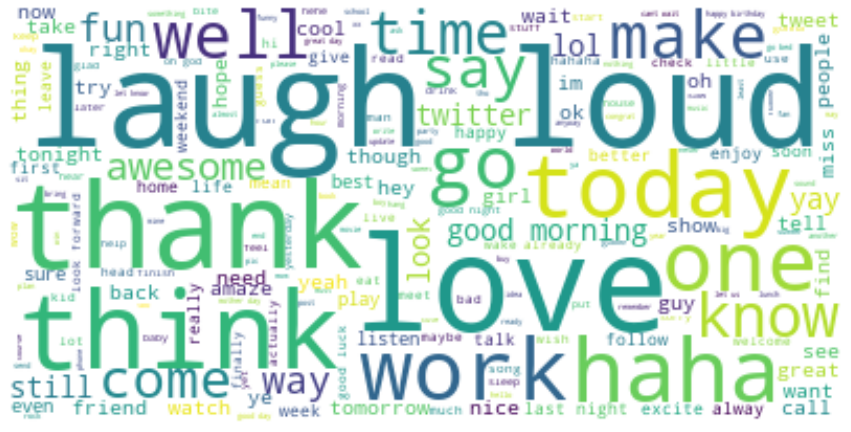

In [ ]:
wordcloud_real = WordCloud(background_color="white").generate(real_text_corpus)

plt.figure(figsize = (15,15))
plt.imshow(wordcloud_real, interpolation='bilinear')
plt.axis("off")
plt.show()

Keep only text and target column in the dataset

In [ ]:
data_target_0 = data.loc[data['target']==0]
data_target_1 = data.loc[data['target']==4]
data.head()

,target,text
0,0,upset cannot update facebook texting it might ...
1,0,kenichan dive many time ball manage save 50 re...
2,0,whole body feel itchy like fire
3,0,nationwideclass no behave all mad here cannot ...
4,0,kwesidei whole crew


Print the count of unique words

In [ ]:
all_corpus = build_corpus(data['text'])
print(len(all_corpus))

12433378


Corpus of target column

In [ ]:
all_text_corpus = " ".join(all_corpus)
filtered_words = [word for word in all_text_corpus.split() if word not in STOPWORDS]
counted_words = collections.Counter(filtered_words)

word_count = {}

for letter, count in counted_words.most_common(30):
    word_count[letter] = count
    
for i,j in word_count.items():
        print('{0} => {1}'.format(i,j))

get => 172363
go => 163510
good => 89603
work => 85190
day => 82649
like => 82319
love => 76810
today => 64682
time => 64520
think => 61116
thank => 60500
know => 60128
want => 57078
see => 57016
back => 56922
miss => 56679
make => 56264
one => 52385
im => 51063
feel => 50705
really => 49384
cannot => 47046
oh => 46086
laugh => 45314
come => 44608
watch => 43151
need => 42928
still => 42864
new => 42149
well => 41162


In [ ]:
#Total unique words
print(len(list(counted_words.keys())))
#print(counted_words.keys())

753901


Computed first 15 (more frequent) word list 

In [ ]:
print((counted_words.most_common(15)))
list1=[]
list2=[]
most_freq_list = counted_words.most_common(15)
for i in most_freq_list:
  list1.append(i[0])
  list2.append(i[1])

[('get', 172363), ('go', 163510), ('good', 89603), ('work', 85190), ('day', 82649), ('like', 82319), ('love', 76810), ('today', 64682), ('time', 64520), ('think', 61116), ('thank', 60500), ('know', 60128), ('want', 57078), ('see', 57016), ('back', 56922)]


Plot of top frequent 15 words V/S their count

Text(0, 0.5, 'Count')

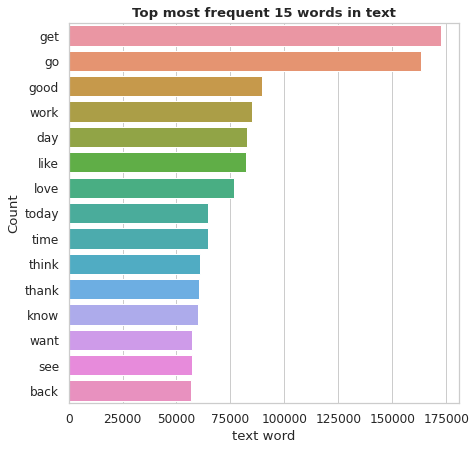

In [ ]:
plt.title('Top most frequent 15 words in text',fontweight='bold')
sns.barplot(y=list1,x=list2)
plt.xlabel('text word')
plt.ylabel('Count')
#plt.xticks(rotation=45)

Frequency of words in class 0 and 1

Frequency of words in class 0

In [ ]:
fake_text_corpus

In [ ]:
filtered_words = [word for word in fake_text_corpus.split() if word not in STOPWORDS]
counted_words_fake = collections.Counter(filtered_words)

word_count = {}

for letter, count in counted_words_fake.most_common(30):
    word_count[letter] = count
    
for i,j in word_count.items():
        print('{0} => {1}'.format(i,j))

go => 95620
get => 95182
work => 57316
miss => 47414
like => 42444
want => 40133
day => 38106
feel => 36572
today => 36220
back => 33080
cannot => 32490
think => 32265
really => 31127
time => 31014
know => 30797
im => 30750
still => 28787
good => 28612
make => 27425
sad => 27150
oh => 26617
one => 26431
need => 26237
wish => 25987
see => 25763
home => 23971
come => 22866
last => 22481
sleep => 21933
2 => 21913


Total unique words in class 0

In [ ]:
print(len(list(counted_words_fake.keys())))

418034


Computed first 15 (more frequent) word list for class 0

In [ ]:
print((counted_words_fake.most_common(15)))
list1=[]
list2=[]
most_freq_list = counted_words_fake.most_common(15)
for i in most_freq_list:
  list1.append(i[0])
  list2.append(i[1])

[('go', 95620), ('get', 95182), ('work', 57316), ('miss', 47414), ('like', 42444), ('want', 40133), ('day', 38106), ('feel', 36572), ('today', 36220), ('back', 33080), ('cannot', 32490), ('think', 32265), ('really', 31127), ('time', 31014), ('know', 30797)]


Plot of top frequent 15 words V/S their count for class 0

Text(0, 0.5, 'Count')

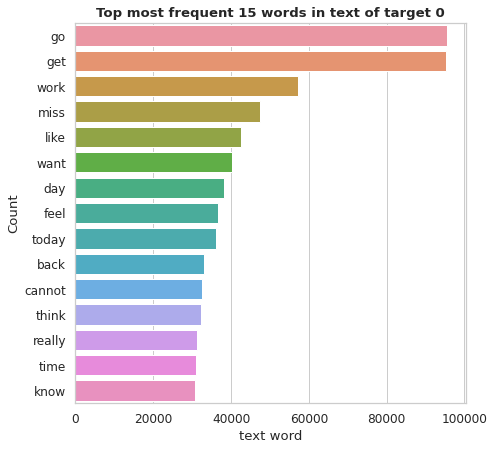

In [ ]:
plt.title('Top most frequent 15 words in text of target 0',fontweight='bold')
sns.barplot(y=list1,x=list2)
plt.xlabel('text word')
plt.ylabel('Count')

Frequency of words in class 1

In [ ]:
real_text_corpus

In [ ]:
filtered_words = [word for word in real_text_corpus.split() if word not in STOPWORDS]
counted_words_real = collections.Counter(filtered_words)

word_count = {}

for letter, count in counted_words_real.most_common(30):
    word_count[letter] = count
    
for i,j in word_count.items():
        print('{0} => {1}'.format(i,j))

get => 77181
go => 67890
good => 60991
love => 56552
thank => 52135
day => 44543
like => 39875
time => 33506
see => 31253
know => 29331
think => 28851
make => 28839
today => 28462
work => 27874
laugh => 27121
new => 26739
one => 25954
great => 25177
watch => 25172
back => 23842
loud => 23261
well => 22375
night => 22101
come => 21742
shall => 21724
look => 21529
haha => 20794
twitter => 20420
im => 20313
happy => 20203


Total unique words in class 1

In [ ]:
print(len(list(counted_words_real.keys())))

487131


Computed first 15 (more frequent) word list for class 1

In [ ]:
print((counted_words_real.most_common(15)))
list1=[]
list2=[]
most_freq_list = counted_words_real.most_common(15)
for i in most_freq_list:
  list1.append(i[0])
  list2.append(i[1])

[('get', 77181), ('go', 67890), ('good', 60991), ('love', 56552), ('thank', 52135), ('day', 44543), ('like', 39875), ('time', 33506), ('see', 31253), ('know', 29331), ('think', 28851), ('make', 28839), ('today', 28462), ('work', 27874), ('laugh', 27121)]


Plot of top frequent 15 words V/S their count for class 1

Text(0, 0.5, 'Count')

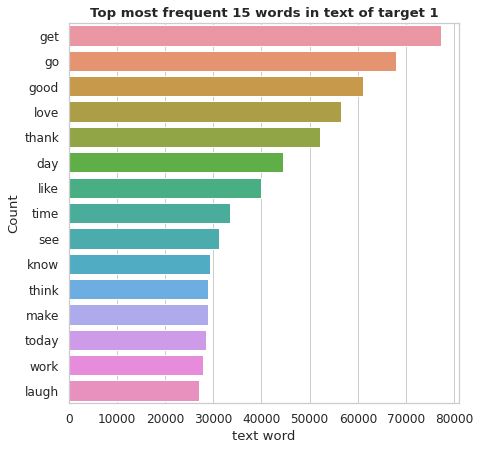

In [ ]:
plt.title('Top most frequent 15 words in text of target 1',fontweight='bold')
sns.barplot(y=list1,x=list2)
plt.xlabel('text word')
plt.ylabel('Count')

Does the sum of the unique words in target 0 and 1 sum upto the total number of unique words in the whole document?

Sum of unique words in target 0 is 418034 and sum of unique words in target 1 is 
487131 and there sum is 905165 and this is not equal to the total number of unique words in the whole documents ,as total unique words are 753901.This dismatch arises because there are some words common in target 0 and target 1 .Hence while adding unique words of target 0 and target 1,we counted twice those words that are common in both.

Total frequency

In [ ]:
#Calculation of these frquency has been already done in previous codes while drawing word cloud and obtaining corpus
print("The total frequecy of word in the whole text column of document is : ",len(all_corpus))

The total frequecy of word in the whole text column of document is :  12433378


In [ ]:
#Calculation of these frquency has been already done in previous codes while drawing word cloud and obtaining corpus
print("The total frequecy of word in the whole text column of document with target as 0 is : ",len(fake_corpus))

The total frequecy of word in the whole text column of document with target as 0 is :  6286937


In [ ]:
#Calculation of these frquency has been already done in previous codes while drawing word cloud and obtaining corpus
print("The total frequecy of word in the whole text column of document with target as 1 is : ",len(real_corpus))

The total frequecy of word in the whole text column of document with target as 1 is :  6146441


Sum of frequency of both the classes is equal to the Total frequency.

Visualizing Top N-grams

In [ ]:


## visualising top n-grams

def get_top_word_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

def get_top_word_trigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [ ]:
def plot_confussion_matrix(y_test, y_pred):
    c_matrix = metrics.confusion_matrix(y_test, y_pred)

    # Create a dataframe with the confussion matrix values
    df_c_matrix = pd.DataFrame(c_matrix, range(c_matrix.shape[0]),
                  range(c_matrix.shape[1]))
    # Plot the confussion matrix
    sns.set(font_scale=1.5) #for label size
    sns.heatmap(df_c_matrix, annot=True,fmt='.0f',annot_kws={"size": 10})# font size
    plt.show()

In [ ]:
def plot_roc_curve(y_test, y_pred):
    ''' Plot the ROC curve for the target labels and predictions'''
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=4)
    roc_auc= metrics.auc(fpr,tpr)

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.legend()
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

Visualization of bi-Gram and tri-gram for whole document for train dataset using Count Vectorizer

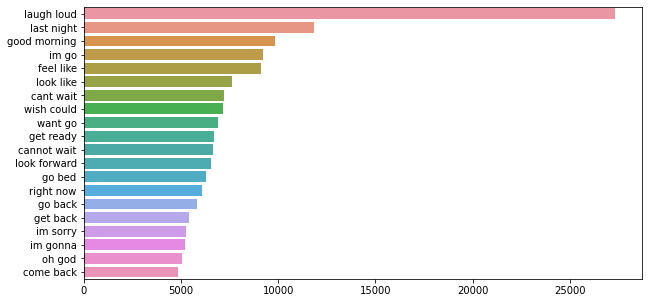

In [ ]:
plt.figure(figsize=(10,5))
top_tweet_bigrams=get_top_word_bigrams(data['text'])[:20]
x,y=map(list,zip(*top_tweet_bigrams))
sns.barplot(x=y,y=x)

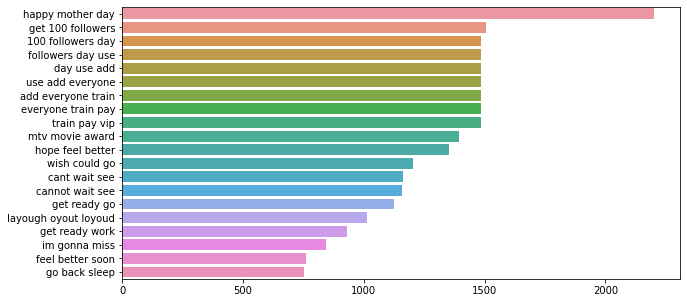

In [ ]:
plt.figure(figsize=(10,5))
top_tweet_trigrams=get_top_word_trigrams(data['text'])[:20]
x,y=map(list,zip(*top_tweet_trigrams))
sns.barplot(x=y,y=x)

Visualization bi-Gram and tri-gram for document with target 0 using Count Vectorizer

---



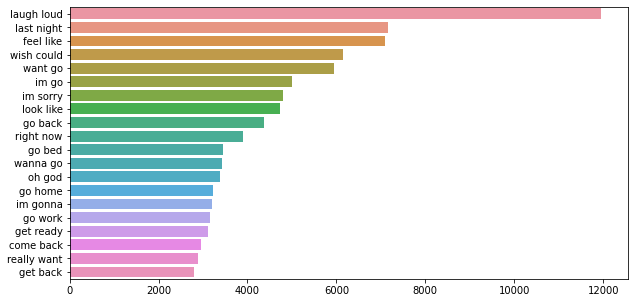

In [ ]:
plt.figure(figsize=(10,5))
top_tweet_bigrams=get_top_word_bigrams(data_target_0['text'])[:20]
x,y=map(list,zip(*top_tweet_bigrams))
sns.barplot(x=y,y=x)

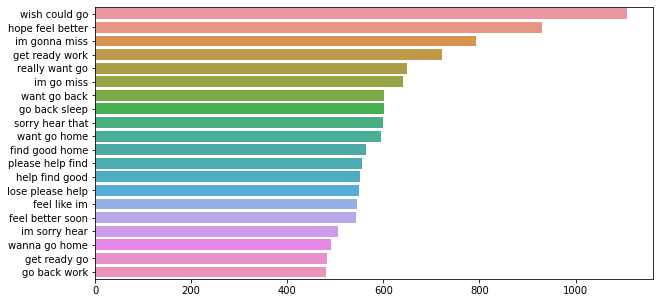

In [ ]:
plt.figure(figsize=(10,5))
top_tweet_trigrams=get_top_word_trigrams(data_target_0['text'])[:20]
x,y=map(list,zip(*top_tweet_trigrams))
sns.barplot(x=y,y=x)

Visualization of N-Gram for document with target 1 using Count Vectorizer

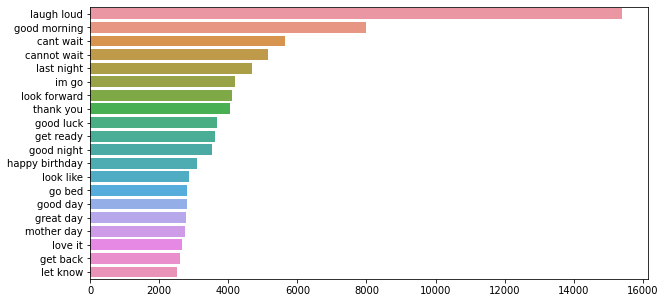

In [ ]:
plt.figure(figsize=(10,5))
top_tweet_bigrams=get_top_word_bigrams(data_target_1['text'])[:20]
x,y=map(list,zip(*top_tweet_bigrams))
sns.barplot(x=y,y=x)

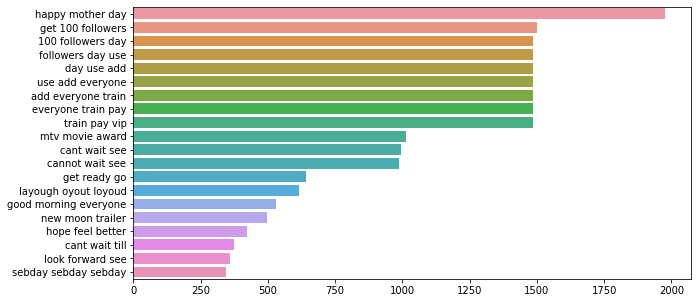

In [ ]:
plt.figure(figsize=(10,5))
top_tweet_trigrams=get_top_word_trigrams(data_target_1['text'])[:20]
x,y=map(list,zip(*top_tweet_trigrams))
sns.barplot(x=y,y=x)

Feature Extraction using TF-IDF and comparing model

In [ ]:
def get_feature_vector(train_fit):
    vector = TfidfVectorizer(sublinear_tf=True)
    vector.fit(train_fit)
    return vector

In [ ]:
tf_vector = get_feature_vector(np.array(data.iloc[:, 1]).ravel())
X = tf_vector.transform(np.array(data.iloc[:, 1]).ravel())
y_vector = np.array(data.iloc[:, 0]).ravel()
X_train, X_test, y_train, y_test = train_test_split(X, y_vector, test_size=0.2, random_state=30)



In [ ]:
print(X.shape)

(1599999, 752141)


In [ ]:
# Training Naive Bayes model
NB_model = MultinomialNB()
NB_model.fit(X_train, y_train)
y_predict_nb = NB_model.predict(X_test)
print("Train score of logistic Naive Bayes classfier : ",NB_model.score(X_train,y_train),"%")
print("Accuracy of Naive Bayes classifier :",metrics.accuracy_score(y_test, y_predict_nb),"%")

Train score of logistic Naive Bayes classfier :  0.8388358115904778 %
Accuracy of Naive Bayes classifier : 0.757775 %


In [ ]:
cv_score_tfidf_nb = cross_val_score(NB_model, X_train, y_train, cv=5, scoring='accuracy')
cv_score_tfidf_nb

array([0.75505859, 0.75718359, 0.75573047, 0.75446875, 0.75485842])

In [ ]:
print("The accuracy using 5-fold cross validation is %.5f with std deviation of %.5f" %(np.mean(cv_score_tfidf_nb),np.std(cv_score_tfidf_nb)))

The accuracy using 5-fold cross validation is 0.75546 with std deviation of 0.00095


In [ ]:
print(metrics.classification_report(y_test, y_predict_nb))

              precision    recall  f1-score   support

           0       0.74      0.79      0.77    160465
           4       0.77      0.73      0.75    159535

    accuracy                           0.76    320000
   macro avg       0.76      0.76      0.76    320000
weighted avg       0.76      0.76      0.76    320000



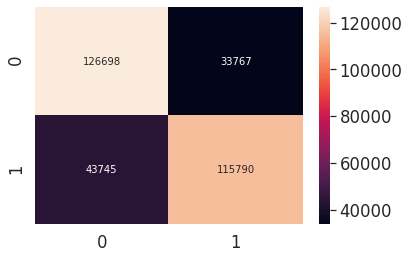

In [ ]:
plot_confussion_matrix(y_test,y_predict_nb)

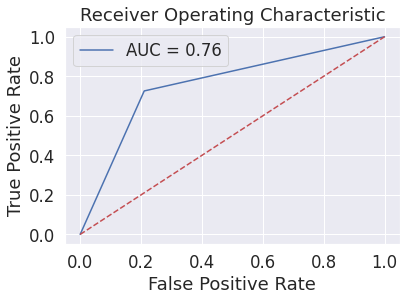

In [ ]:
plot_roc_curve(y_test, y_predict_nb)

In [ ]:
# Training Logistics Regression model
LR_model = LogisticRegression()
LR_model.fit(X_train,y_train)
y_predict_lr = LR_model.predict(X_test)
print("Train score of logistic regression",LR_model.score(X_train,y_train),"%")
print("Accuracy of logistic regression classifier :",metrics.accuracy_score(y_test, y_predict_lr),"%")

Train score of logistic regression 0.8138404795628746 %
Accuracy of logistic regression classifier : 0.778534375 %


In [ ]:
cv_score_tfidf_lr = cross_val_score(LR_model, X_train, y_train, cv=5, scoring='accuracy')
cv_score_tfidf_lr

array([0.77765234, 0.77875781, 0.77785156, 0.77626562, 0.77731163])

In [ ]:
print("The accuracy using 5-fold cross validation is %.5f with std deviation of %.5f" %(np.mean(cv_score_tfidf_lr),np.std(cv_score_tfidf_lr)))

The accuracy using 5-fold cross validation is 0.77757 with std deviation of 0.00081


In [ ]:
print(metrics.classification_report(y_test, y_predict_lr))

              precision    recall  f1-score   support

           0       0.79      0.75      0.77    160465
           4       0.76      0.80      0.78    159535

    accuracy                           0.78    320000
   macro avg       0.78      0.78      0.78    320000
weighted avg       0.78      0.78      0.78    320000



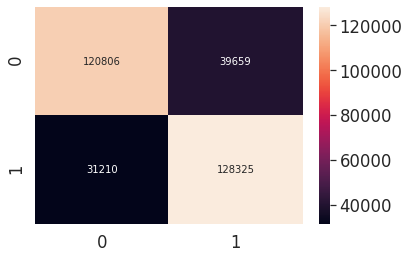

In [ ]:
plot_confussion_matrix(y_test,y_predict_lr)

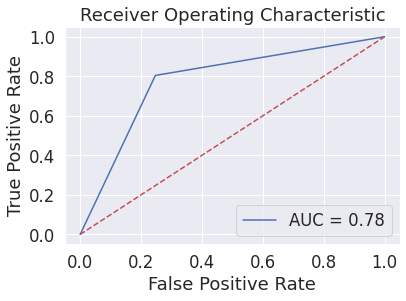

In [ ]:
plot_roc_curve(y_test, y_predict_lr)

Feature Extraction Using Bi-Gram and comparing model

In [ ]:
vectorizer_bi = TfidfVectorizer(ngram_range=(2,2)) # You can still specify n-grams here.
X_bi = vectorizer_bi.fit_transform(data['text'])

In [ ]:
X_train_bi, X_test_bi, y_train_bi, y_test_bi = train_test_split(X_bi, y_vector, test_size=0.2, random_state=30)

In [ ]:
print(X_bi.shape)

(1599999, 4656040)


In [ ]:
# Training Naive Bayes model
NB_model = MultinomialNB()
NB_model.fit(X_train_bi, y_train_bi)
y_predict_nb = NB_model.predict(X_test_bi)
print("Train score of logistic Naive Bayes classfier : ",NB_model.score(X_train_bi,y_train_bi),"%")
print("Accuracy of Naive Bayes classifier :",metrics.accuracy_score(y_test_bi, y_predict_nb),"%")

Train score of logistic Naive Bayes classfier :  0.9399858906139771 %
Accuracy of Naive Bayes classifier : 0.740046875 %


In [ ]:
cv_score_tfidf_nb = cross_val_score(NB_model, X_train_bi, y_train_bi, cv=5, scoring='accuracy')
cv_score_tfidf_nb

array([0.7359375 , 0.73659375, 0.73405078, 0.73419922, 0.73653022])

In [ ]:
print("The accuracy using 5-fold cross validation is %.5f with std deviation of %.5f" %(np.mean(cv_score_tfidf_nb),np.std(cv_score_tfidf_nb)))

The accuracy using 5-fold cross validation is 0.73546 with std deviation of 0.00112


In [ ]:
print(metrics.classification_report(y_test_bi, y_predict_nb))

              precision    recall  f1-score   support

           0       0.74      0.74      0.74    160465
           4       0.74      0.74      0.74    159535

    accuracy                           0.74    320000
   macro avg       0.74      0.74      0.74    320000
weighted avg       0.74      0.74      0.74    320000



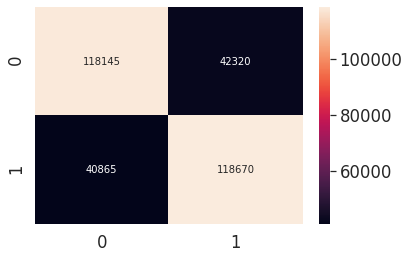

In [ ]:
plot_confussion_matrix(y_test_bi,y_predict_nb)

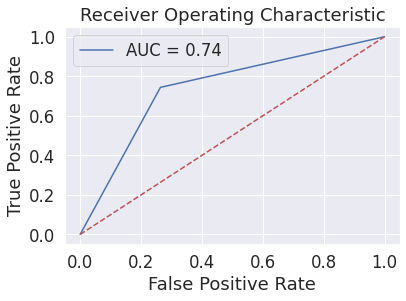

In [ ]:
plot_roc_curve(y_test_bi, y_predict_nb)

In [ ]:
# Training Logistics Regression model
LR_model = LogisticRegression()
LR_model.fit(X_train_bi,y_train_bi)
y_predict_lr = LR_model.predict(X_test_bi)
print("Train score of logistic regression",LR_model.score(X_train_bi,y_train_bi),"%")
print("Accuracy of logistic regression classifier :",metrics.accuracy_score(y_test_bi, y_predict_lr),"%")

Train score of logistic regression 0.9026092989135148 %
Accuracy of logistic regression classifier : 0.733915625 %


In [ ]:
cv_score_tfidf_lr = cross_val_score(LR_model, X_train_bi, y_train_bi, cv=5, scoring='accuracy')
cv_score_tfidf_lr

array([0.72992578, 0.730625  , 0.72905078, 0.72985937, 0.72990519])

In [ ]:
print("The accuracy using 5-fold cross validation is %.5f with std deviation of %.5f" %(np.mean(cv_score_tfidf_lr),np.std(cv_score_tfidf_lr)))

The accuracy using 5-fold cross validation is 0.72987 with std deviation of 0.00050


In [ ]:
print(metrics.classification_report(y_test_bi, y_predict_lr))

              precision    recall  f1-score   support

           0       0.78      0.65      0.71    160465
           4       0.70      0.82      0.75    159535

    accuracy                           0.73    320000
   macro avg       0.74      0.73      0.73    320000
weighted avg       0.74      0.73      0.73    320000



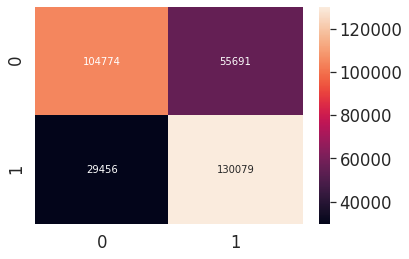

In [ ]:
plot_confussion_matrix(y_test_bi,y_predict_lr)

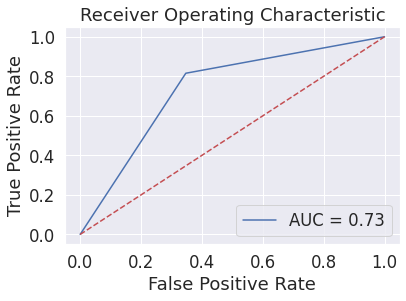

In [ ]:
plot_roc_curve(y_test_bi, y_predict_lr)

Feature Extraction using Tri-Gram and comparing model

In [ ]:
vectorizer_tri = TfidfVectorizer(ngram_range=(3,3)) # You can still specify n-grams here.
X_tri = vectorizer_tri.fit_transform(data['text'])

In [ ]:
X_train_tri, X_test_tri, y_train_tri, y_test_tri = train_test_split(X_tri, y_vector, test_size=0.2, random_state=30)

In [ ]:
print(X_tri.shape)

(1599999, 7861680)


In [ ]:
# Training Naive Bayes model
NB_model = MultinomialNB()
NB_model.fit(X_train_tri, y_train_tri)
y_predict_nb = NB_model.predict(X_test_tri)
print("Train score of logistic Naive Bayes classfier : ",NB_model.score(X_train_tri,y_train_tri),"%")
print("Accuracy of Naive Bayes classifier :",metrics.accuracy_score(y_test_tri, y_predict_nb),"%")

Train score of logistic Naive Bayes classfier :  0.9592491869134273 %
Accuracy of Naive Bayes classifier : 0.617453125 %


In [ ]:
cv_score_tfidf_nb = cross_val_score(NB_model, X_train_tri, y_train_tri, cv=5, scoring='accuracy')
cv_score_tfidf_nb

array([0.61122266, 0.61324609, 0.61121875, 0.61014062, 0.61152583])

In [ ]:
print("The accuracy using 5-fold cross validation is %.5f with std deviation of %.5f" %(np.mean(cv_score_tfidf_nb),np.std(cv_score_tfidf_nb)))

The accuracy using 5-fold cross validation is 0.61147 with std deviation of 0.00100


In [ ]:
print(metrics.classification_report(y_test_tri, y_predict_nb))

              precision    recall  f1-score   support

           0       0.73      0.37      0.49    160465
           4       0.58      0.87      0.69    159535

    accuracy                           0.62    320000
   macro avg       0.66      0.62      0.59    320000
weighted avg       0.66      0.62      0.59    320000



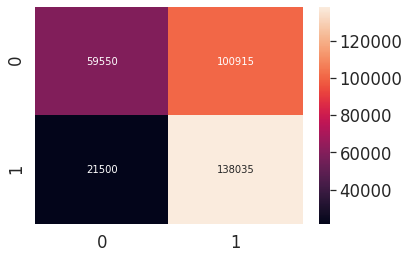

In [ ]:
plot_confussion_matrix(y_test_tri,y_predict_nb)

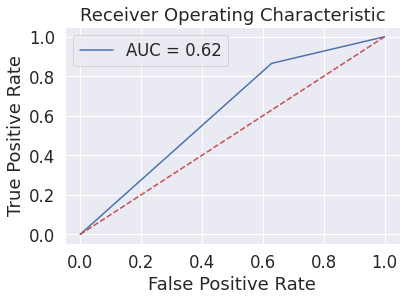

In [ ]:
plot_roc_curve(y_test_tri, y_predict_nb)

In [ ]:
# Training Logistics Regression model
LR_model = LogisticRegression()
LR_model.fit(X_train_tri,y_train_tri)
y_predict_lr = LR_model.predict(X_test_tri)
print("Train score of logistic regression",LR_model.score(X_train_tri,y_train_tri),"%")
print("Accuracy of logistic regression classifier :",metrics.accuracy_score(y_test_tri, y_predict_lr),"%")

Train score of logistic regression 0.9527171505602738 %
Accuracy of logistic regression classifier : 0.615090625 %


In [ ]:
cv_score_tfidf_lr = cross_val_score(LR_model, X_train_tri, y_train_tri, cv=5, scoring='accuracy')
cv_score_tfidf_lr

array([0.60944922, 0.61129297, 0.60951172, 0.60819531, 0.60910394])

In [ ]:
print("The accuracy using 5-fold cross validation is %.5f with std deviation of %.5f" %(np.mean(cv_score_tfidf_lr),np.std(cv_score_tfidf_lr)))

The accuracy using 5-fold cross validation is 0.60951 with std deviation of 0.00101


In [ ]:
print(metrics.classification_report(y_test_tri, y_predict_lr))

              precision    recall  f1-score   support

           0       0.74      0.36      0.48    160465
           4       0.58      0.87      0.69    159535

    accuracy                           0.62    320000
   macro avg       0.66      0.62      0.59    320000
weighted avg       0.66      0.62      0.59    320000



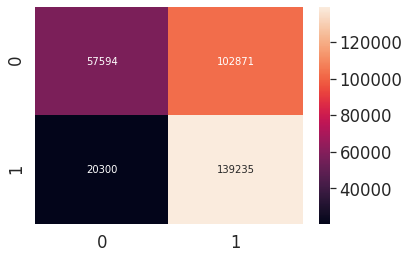

In [ ]:
plot_confussion_matrix(y_test_tri,y_predict_lr)

In [ ]:
y_test_tri

array([4, 4, 4, ..., 0, 4, 4])

In [ ]:
y_predict_lr

array([4, 0, 4, ..., 4, 4, 4])

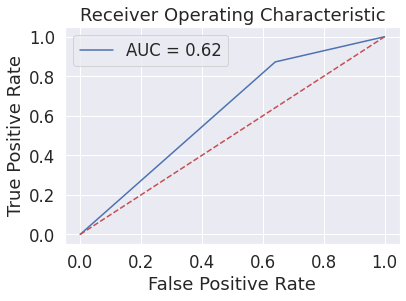

In [ ]:
plot_roc_curve(y_test_tri, y_predict_lr)

Feature Extraction using (1,2) gram and comparing model

In [ ]:
vectorizer_1_2 = TfidfVectorizer(ngram_range=(1,2)) # You can still specify n-grams here.
X_1_2 = vectorizer_1_2.fit_transform(data['text'])

In [ ]:
X_train_1_2, X_test_1_2, y_train_1_2, y_test_1_2 = train_test_split(X_1_2, y_vector, test_size=0.2, random_state=30)

In [ ]:
print(X_1_2.shape)

(1599999, 5408181)


In [ ]:
# Training Naive Bayes model
NB_model = MultinomialNB()
NB_model.fit(X_train_1_2, y_train_1_2)
y_predict_nb = NB_model.predict(X_test_1_2)
print("Train score of logistic Naive Bayes classfier : ",NB_model.score(X_train_1_2,y_train_1_2),"%")
print("Accuracy of Naive Bayes classifier :",metrics.accuracy_score(y_test_1_2, y_predict_nb),"%")

Train score of logistic Naive Bayes classfier :  0.922822595955153 %
Accuracy of Naive Bayes classifier : 0.780553125 %


In [ ]:
cv_score_tfidf_nb = cross_val_score(NB_model, X_train_1_2, y_train_1_2, cv=5, scoring='accuracy')
cv_score_tfidf_nb

array([0.77786328, 0.77945703, 0.77682812, 0.77661719, 0.77806163])

In [ ]:
print("The accuracy using 5-fold cross validation is %.5f with std deviation of %.5f" %(np.mean(cv_score_tfidf_nb),np.std(cv_score_tfidf_nb)))

The accuracy using 5-fold cross validation is 0.77777 with std deviation of 0.00102


In [ ]:
print(metrics.classification_report(y_test_1_2, y_predict_nb))

              precision    recall  f1-score   support

           0       0.76      0.81      0.79    160465
           4       0.80      0.75      0.77    159535

    accuracy                           0.78    320000
   macro avg       0.78      0.78      0.78    320000
weighted avg       0.78      0.78      0.78    320000



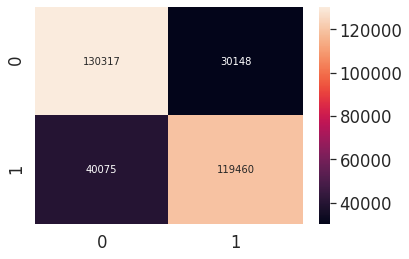

In [ ]:
plot_confussion_matrix(y_test_1_2,y_predict_nb)

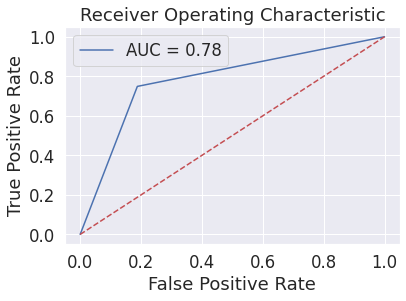

In [ ]:
plot_roc_curve(y_test_1_2, y_predict_nb)

In [ ]:
# Training Logistics Regression model
LR_model = LogisticRegression()
LR_model.fit(X_train_1_2,y_train_1_2)
y_predict_lr = LR_model.predict(X_test_1_2)
print("Train score of logistic regression",LR_model.score(X_train_1_2,y_train_1_2),"%")
print("Accuracy of logistic regression classifier :",metrics.accuracy_score(y_test_1_2, y_predict_lr),"%")

Train score of logistic regression 0.8478553498869921 %
Accuracy of logistic regression classifier : 0.791990625 %


In [ ]:
cv_score_tfidf_lr = cross_val_score(LR_model, X_train_1_2, y_train_1_2, cv=5, scoring='accuracy')
cv_score_tfidf_lr

array([0.79098047, 0.79121094, 0.78944531, 0.78607812, 0.78952652])

In [ ]:
print("The accuracy using 5-fold cross validation is %.5f with std deviation of %.5f" %(np.mean(cv_score_tfidf_lr),np.std(cv_score_tfidf_lr)))

The accuracy using 5-fold cross validation is 0.78945 with std deviation of 0.00183


In [ ]:
print(metrics.classification_report(y_test_1_2, y_predict_lr))

              precision    recall  f1-score   support

           0       0.81      0.77      0.79    160465
           4       0.78      0.82      0.80    159535

    accuracy                           0.79    320000
   macro avg       0.79      0.79      0.79    320000
weighted avg       0.79      0.79      0.79    320000



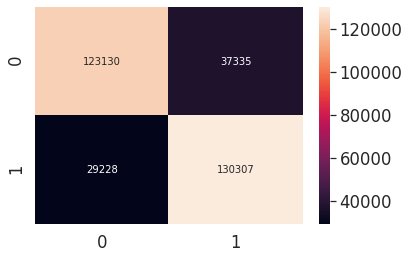

In [ ]:
plot_confussion_matrix(y_test_1_2,y_predict_lr)

In [ ]:
y_test_1_2

array([4, 4, 4, ..., 0, 4, 4])

In [ ]:
y_predict_lr

array([4, 4, 4, ..., 0, 4, 4])

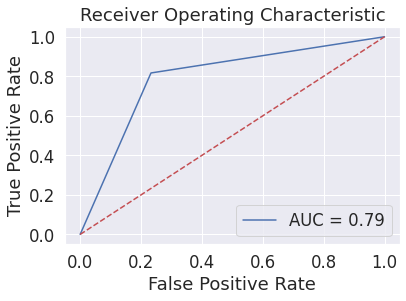

In [ ]:
plot_roc_curve(y_test_1_2, y_predict_lr)

# ***Thank You :)***